# Exploration of testis dataset

### Common Imports

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import torch
import numpy
import matplotlib.pyplot as plt
from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel, show_batch
from tissue_purifier.plot_utils.plot_misc import plot_composition

In [3]:
import neptune.new as neptune
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTkyYmJiYi0wN2E1LTRkY2YtOWU3Ny1kNjhjYmM3ZTVkNWEifQ=="
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

DM = SlideSeqTestisDM
dataset = "testis_dataset" 
logging_mode = "async" # or "offline" 

exp: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_TOKEN,
                                    mode=logging_mode,
                                    tags=dataset)

https://app.neptune.ai/cellarium/tissue-purifier/e/TIS-1462
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Use default dictionary (or modify it)

In [4]:
# Dictionary from configuration file
# import yaml
# 
# file_yaml = "config_testis_dino_v7.yaml"
# with open(file_yaml, 'r') as stream:
#     config_dict = yaml.safe_load(stream)

# Default ictionary 
config_dict = DM.get_default_params()
    
config_dict['n_crops_for_tissue_test'] = 20
config_dict['dropout_range'] = [0.0, 0.2]
config_dict['cohort'] = 'all'


# Create the datamodule

In [5]:
# print(config_dict)

dm = DM(**config_dict)
dm.prepare_data()
dm.setup(stage=None)

-----> running datamodule init
-----> running datamodule prepare_data
Will create the test and train file
untar data
number of elements ---> 31659
mean and median spacing 15.622264926052864, 15.420071793081707
The dense shape of the image is -> torch.Size([9, 1178, 1178])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 31649     5]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 31629    15]
number of elements ---> 33059
mean and median spacing 15.358030584634598, 15.508166323067783
The dense shape of the image is -> torch.Size([9, 1180, 855])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 33033    13]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 32973    43]
number of elements ---> 39206
mean and median spacing 15.535967840319682, 15.438280914030202
The dense shape of the image is -> torch.Size([9, 1179, 1180])
Occupacy (ze

## Log the transform

In [6]:
exp["transform/local"] = dm.trsfm_train_local
exp["transform/global"] = dm.trsfm_train_global
exp["transform/test"] = dm.trsfm_test

## check the dataloader

In [7]:
from collections import Counter

batch = next(iter(dm.train_dataloader()))
list_imgs, list_labels, list_metadata = batch
f_names = [metadata.f_name for metadata in list_metadata]

print("----")
print("CHECK")
print("composition of one minibatch -->", Counter(f_names))

Inside train_dataloader cuda
All cat_to_codes dictionaries are identical {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
created train_dataset device = cuda:0, length = 3600
----
CHECK
composition of one minibatch --> Counter({'dis1': 14, 'dis2': 13, 'wt2': 11, 'wt3': 11, 'wt1': 9, 'dis3': 6})


## get the full size images

In [9]:
from tissue_purifier.data_utils.transforms import *
from tissue_purifier.model_utils.analyzer import Composition

dense_and_raster =torchvision.transforms.Compose([
    SparseToDense(), 
    Rasterize(sigma=dm.rasterize_sigma, normalize=False)])

train_dataset = dm.train_dataloader().dataset
sparse_imgs = train_dataset.imgs
dense_imgs = [dense_and_raster(sp_image.data) for sp_image in sparse_imgs]
compositions = Composition(return_fraction=False)(sparse_imgs)

print("---")
print("")
for f_name, dense_img, comp in zip(f_names, dense_imgs, compositions):
    print("Image {0} size -> {1}".format(f_name, dense_img.shape))
    print("#cells by type -> {1}".format(dense_img.shape, comp.cpu().numpy()))
    print("")

Inside train_dataloader cuda
All cat_to_codes dictionaries are identical {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
created train_dataset device = cuda:0, length = 3600
---

Image wt2 size -> torch.Size([9, 1178, 1178])
#cells by type -> [9903  558  321  846  894 6337 8311 2187 2302]

Image dis1 size -> torch.Size([9, 1180, 855])
#cells by type -> [11128   513   225   749  1297  6813  7955  2172  2207]

Image wt2 size -> torch.Size([9, 1179, 1180])
#cells by type -> [14006   446   266   766  1176  9044  9365  2224  1913]

Image wt3 size -> torch.Size([9, 1176, 1180])
#cells by type -> [7477  443  381  731  794 7753 5149 2599 1867]

Image dis1 size -> torch.Size([9, 1180, 1180])
#cells by type -> [17062   529   358   846  1093  6316 10442  2497  3633]

Image dis2 size -> torch.Size([9, 1164, 1165])
#cells by type -> [12552   417   340   623   969  6780  8069  2238  1453]



## Plot Cell composition at the tissue level

In [10]:
fractions = Composition(return_fraction=True)(sparse_imgs)
f_names = [metadata.f_name for metadata in  train_dataset.metadatas]
cell_names = list(train_dataset.imgs[0]._categories_to_codes.keys())

fig_cell_count = plot_composition(
    fractions, 
    dataset_labels=f_names, 
    x_labels=cell_names,
    title="Tissue Compositions",
    figsize=(9,9),
)
exp["cell_counts"].log(neptune.types.File.as_image(fig_cell_count))

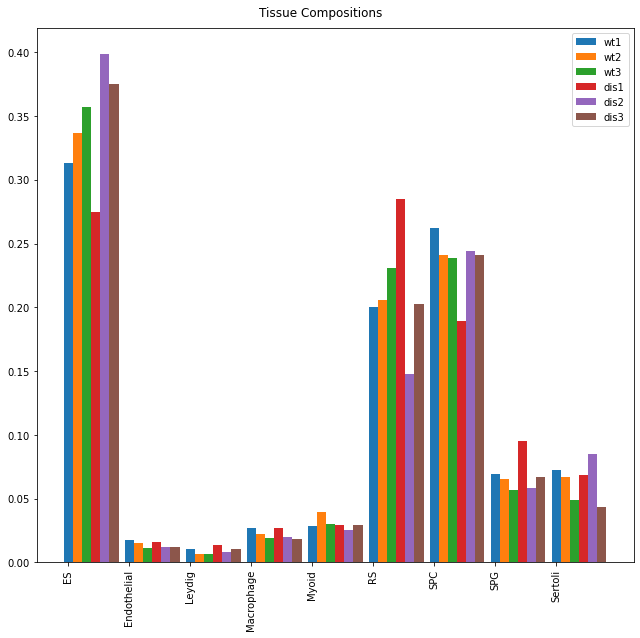

In [11]:
fig_cell_count

## Full Images

In [13]:
list_fig_all_channel = []
list_fig_one_channel = []
for n,(composition, dense_img, f_name) in enumerate(zip(compositions, dense_imgs, f_names)):

    counts = str(composition.cpu().numpy().tolist())
        
    titles = [a+" -> {0}".format(b.item()) for a,b in zip(list(cell_names),composition)]

    fig_all_channel = show_raw_all_channels(dense_img, cmap="tab20", n_col=3, figsize=(12,12), 
                                            sup_title=f_name + "-->" + counts, 
                                            legend_colorbar=list(cell_names))
    fig_one_channel = show_raw_one_channel(dense_img, cmap='gray', n_col=3, figsize=(10,10), 
                                           sup_title=f_name, 
                                           titles=titles)
    exp["full_sample/all_channels"].log(neptune.types.File.as_image(fig_all_channel))
    exp["full_sample/one_channel"].log(neptune.types.File.as_image(fig_one_channel))
    list_fig_one_channel.append(fig_one_channel)
    list_fig_all_channel.append(fig_all_channel)

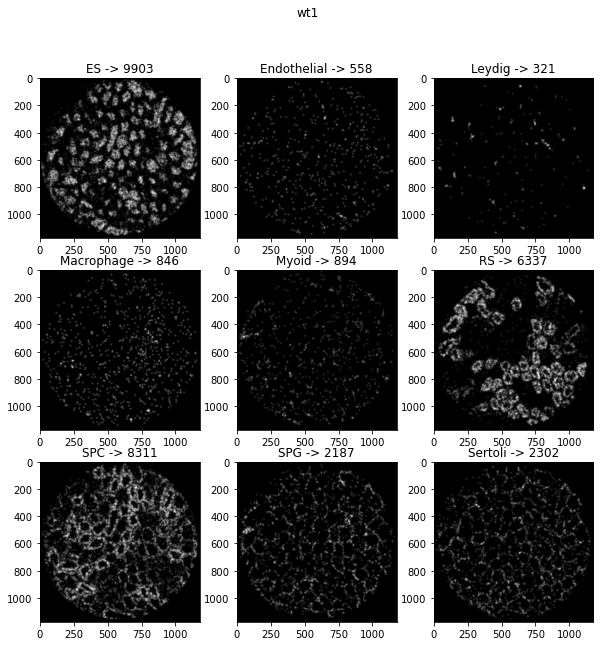

In [14]:
list_fig_one_channel[0]

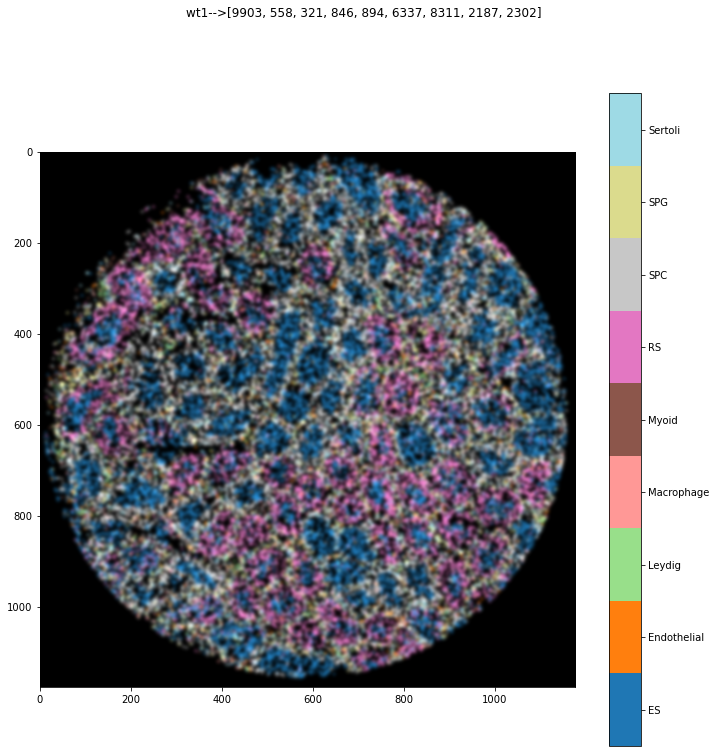

In [15]:
list_fig_all_channel[0]

# Crops

In [16]:
n_iter = 5
n_examples = 5

## Validation dataset

Inside test_dataloader cuda
created test_dataset device = cuda:0, length = 120


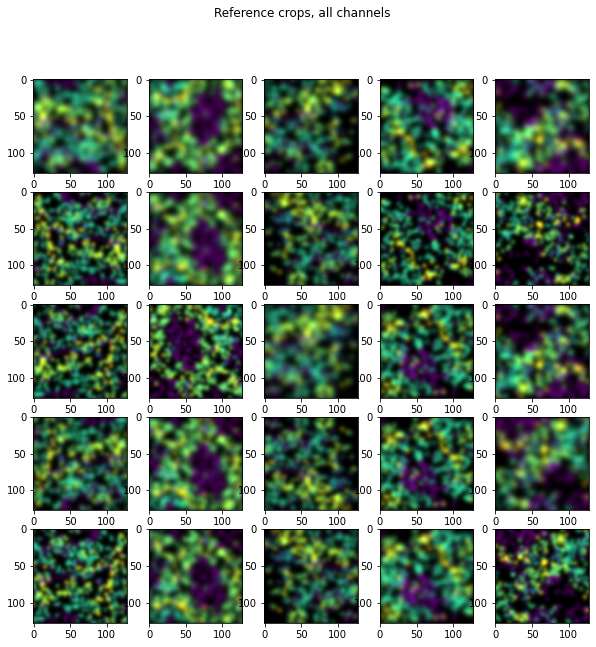

In [17]:
val_dataloader = dm.val_dataloader()[0]
list_sp_imgs, list_labels, list_metas = next(iter(val_dataloader))

all_imgs = []
for n in range(n_iter):
    imgs_tmp = dm.trsfm_test(list_sp_imgs[:n_examples])
    all_imgs.append(imgs_tmp)
    
imgs_ref = torch.cat(all_imgs, dim=0)

ref_all_ch_fig = show_raw_all_channels(imgs_ref, cmap="viridis", n_col=n_examples, figsize=(10,10), sup_title="Reference crops, all channels")
exp["crops/all_channels"].log(neptune.types.File.as_image(ref_all_ch_fig))
ref_all_ch_fig

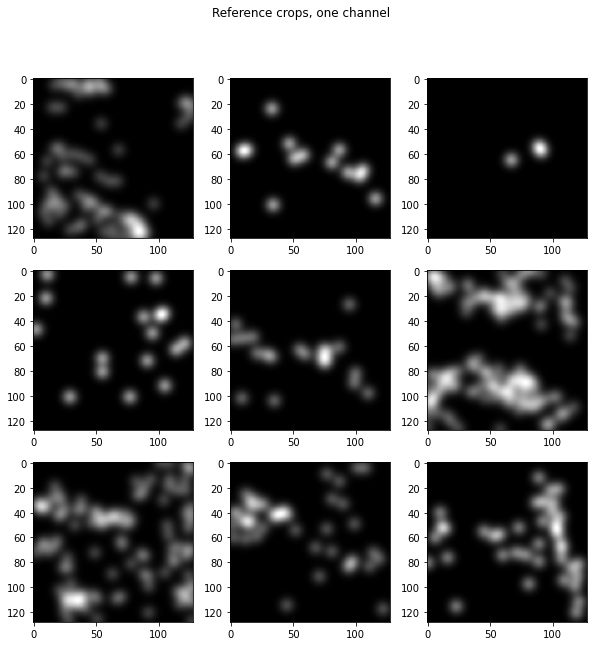

In [18]:
ref_one_ch_fig = show_raw_one_channel(imgs_ref[0], cmap='gray', n_col=3, figsize=(10,10), sup_title="Reference crops, one channel")
exp["crops/one_channel"].log(neptune.types.File.as_image(ref_one_ch_fig))
ref_one_ch_fig

## Local and global

In [19]:
train_dataloader = dm.train_dataloader()
list_img, list_label, list_meta = next(iter(train_dataloader))

all_imgs_local, all_imgs_global = [], []
for n in range(n_iter):
    imgs_tmp_global = dm.trsfm_train_global(list_img[:n_examples])
    imgs_tmp_local = dm.trsfm_train_local(list_img[:n_examples])   
    
    all_imgs_local.append(imgs_tmp_local)
    all_imgs_global.append(imgs_tmp_global)
    
imgs_local = torch.cat(all_imgs_local, dim=0)
imgs_global = torch.cat(all_imgs_global, dim=0)

Inside train_dataloader cuda
All cat_to_codes dictionaries are identical {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
created train_dataset device = cuda:0, length = 3600


### Global

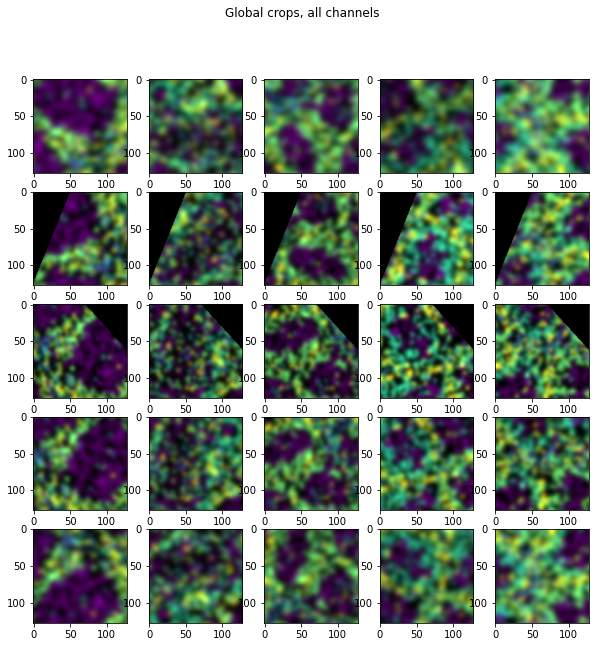

In [20]:
global_all_ch_fig = show_raw_all_channels(imgs_global, cmap="viridis", n_col=n_examples, figsize=(10,10), sup_title="Global crops, all channels")
exp["crops/all_channels"].log(neptune.types.File.as_image(global_all_ch_fig))
global_all_ch_fig

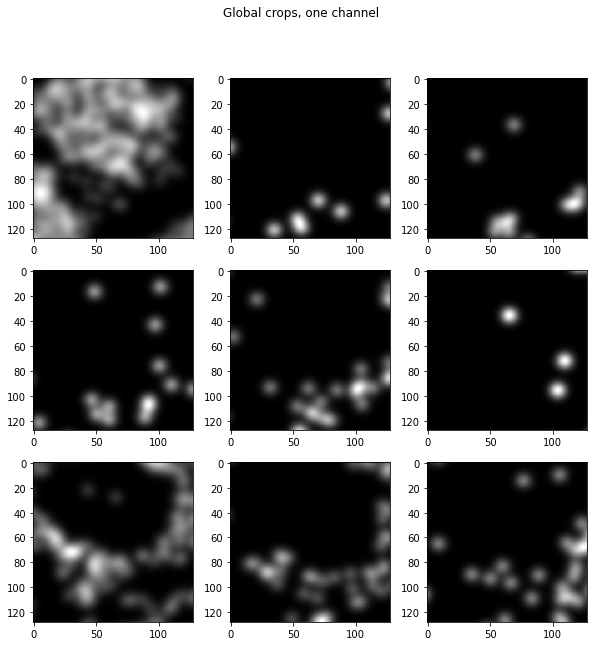

In [21]:
global_one_ch_fig = show_raw_one_channel(imgs_global[0], cmap='gray', n_col=3, figsize=(10,10), sup_title="Global crops, one channel")
exp["crops/one_channel"].log(neptune.types.File.as_image(global_one_ch_fig))
global_one_ch_fig

### Local

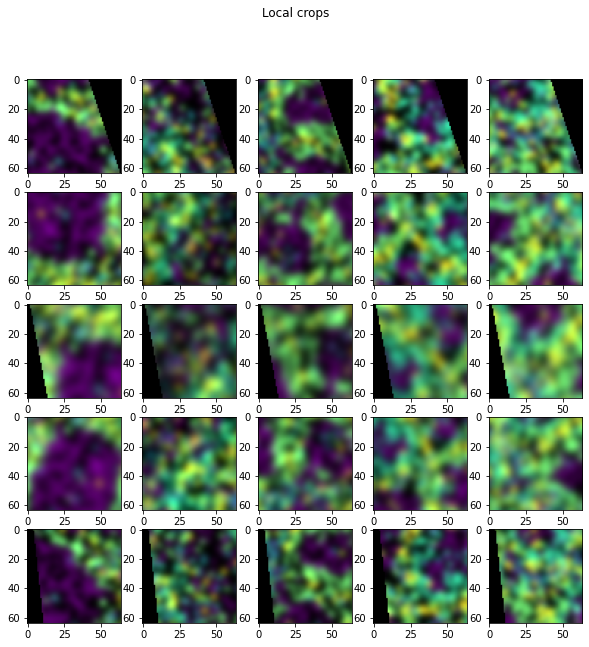

In [22]:
local_all_ch_fig = show_raw_all_channels(imgs_local, cmap="viridis", n_col=n_examples, figsize=(10,10), sup_title="Local crops")
exp["crops/all_channels"].log(neptune.types.File.as_image(local_all_ch_fig))
local_all_ch_fig

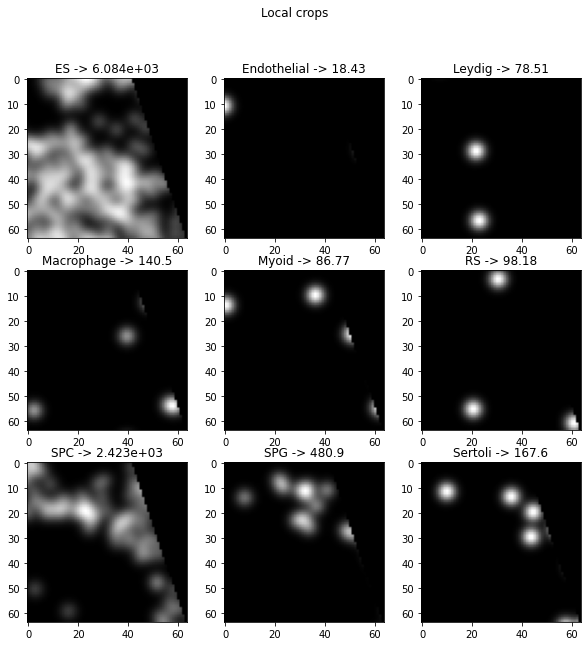

In [23]:
counters = imgs_local[0].sum(dim=(-1,-2))
titles = [a+" -> {0:.4}".format(b.item()) for a,b in zip(list(cell_names),counters)]

local_one_ch_fig = show_raw_one_channel(imgs_local[0], cmap='gray', n_col=3, figsize=(10,10), sup_title="Local crops", titles=titles)
exp["crops/one_channel"].log(neptune.types.File.as_image(local_one_ch_fig))
local_one_ch_fig

In [24]:
exp.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
